# **IMPORT LIBRARIES**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import warnings


# **SETUP**

In [14]:
warnings.filterwarnings('ignore')

# Download NLTK stopwords if not available
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


# **LOAD DATASET**

In [15]:
print("Loading IMDB dataset...")
df = pd.read_csv("IMDB_Dataset.csv")  # Update path if needed
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())



Loading IMDB dataset...
Dataset shape: (50000, 2)

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


# **TEXT PREPROCESSING**

In [16]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Text cleaning pipeline:
    - Lowercasing
    - Removing HTML, URLs, special chars
    - Removing stopwords & short words
    """
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)  # HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # URLs
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Keep only letters
    text = re.sub(r'\s+', ' ', text).strip()  # Extra spaces

    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return ' '.join(words)

print("\nCleaning text data...")
df['clean_review'] = df['review'].apply(clean_text)

# Remove empty cleaned reviews
empty_reviews = df['clean_review'].str.len() == 0
if empty_reviews.sum() > 0:
    print(f"Found {empty_reviews.sum()} empty reviews. Removing them...")
    df = df[~empty_reviews].reset_index(drop=True)



Cleaning text data...


# **FEATURES & LABELS**

In [17]:
X = df['clean_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})

print(f"\nFinal dataset shape: {X.shape}")
print(f"Label distribution: {y.value_counts().to_dict()}")

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")



Final dataset shape: (50000,)
Label distribution: {1: 25000, 0: 25000}

Train set size: 40000
Test set size: 10000


# **TF-IDF VECTORIZATION**

In [18]:
print("\nCreating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")



Creating TF-IDF features...
TF-IDF feature matrix shape: (40000, 10000)


# **MODEL TRAINING**

In [19]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    'Naive Bayes': MultinomialNB(alpha=1.0),
    'SVM': LinearSVC(C=1.0, random_state=42, max_iter=2000)
}

results, predictions = {}, {}

print("\nTraining and evaluating models...")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    predictions[name] = y_pred

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {'Accuracy': accuracy, 'F1-Score': f1}

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    print("-" * 50)




Training and evaluating models...

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.9005
F1-Score: 0.9014

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      5000
    Positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

--------------------------------------------------

Training Naive Bayes...
Naive Bayes Results:
Accuracy: 0.8707
F1-Score: 0.8725

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      5000
    Positive       0.86      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

------------------------------------

# **VISUALIZATIONS**

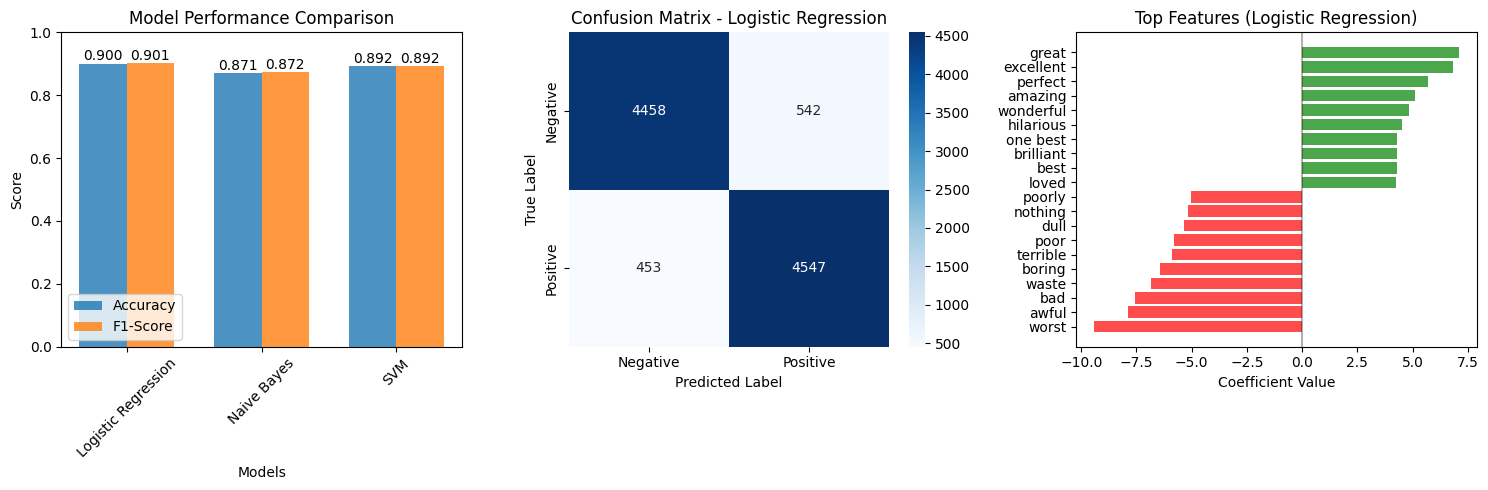

In [20]:
plt.figure(figsize=(15, 5))

# (1) Model Performance
plt.subplot(1, 3, 1)
model_names = list(results.keys())
accuracies = [results[m]['Accuracy'] for m in model_names]
f1_scores = [results[m]['F1-Score'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
plt.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.ylim(0, 1)
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    plt.text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center')
    plt.text(i + width/2, f1 + 0.01, f'{f1:.3f}', ha='center')

# (2) Confusion Matrix of Best Model
best_model = max(results.keys(), key=lambda x: results[x]['F1-Score'])
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, predictions[best_model])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# (3) Top Features (Logistic Regression)
plt.subplot(1, 3, 3)
if 'Logistic Regression' in models:
    feature_names = tfidf.get_feature_names_out()
    coefficients = models['Logistic Regression'].coef_[0]
    top_pos, top_neg = np.argsort(coefficients)[-10:], np.argsort(coefficients)[:10]
    top_features = np.concatenate([top_neg, top_pos])
    feature_labels = [feature_names[i] for i in top_features]
    feature_coefs = coefficients[top_features]
    colors = ['red' if coef < 0 else 'green' for coef in feature_coefs]

    plt.barh(range(len(feature_coefs)), feature_coefs, color=colors, alpha=0.7)
    plt.yticks(range(len(feature_labels)), feature_labels)
    plt.xlabel('Coefficient Value')
    plt.title('Top Features (Logistic Regression)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()


# **SUMMARY**

In [21]:
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Best performing model: {best_model}")
print(f"Best F1-Score: {results[best_model]['F1-Score']:.4f}")
print(f"Best Accuracy: {results[best_model]['Accuracy']:.4f}")

results_df = pd.DataFrame(results).T
print("\nAll Models Comparison:")
print(results_df.round(4))


FINAL RESULTS SUMMARY
Best performing model: Logistic Regression
Best F1-Score: 0.9014
Best Accuracy: 0.9005

All Models Comparison:
                     Accuracy  F1-Score
Logistic Regression    0.9005    0.9014
Naive Bayes            0.8707    0.8725
SVM                    0.8916    0.8919


# **PREDICTION FUNCTIONS**

In [22]:
def predict_sentiment(review_text, model_name=None):
    """ Predict sentiment for a custom review """
    if not review_text.strip():
        return {"error": "Please enter a valid review"}

    clean_review = clean_text(review_text)
    if not clean_review.strip():
        return {"error": "Review contains no meaningful text after cleaning"}

    review_tfidf = tfidf.transform([clean_review])
    predictions = {}

    models_to_use = {model_name: models[model_name]} if model_name and model_name in models else models
    for name, model in models_to_use.items():
        pred = model.predict(review_tfidf)[0]
        sentiment = "Positive" if pred == 1 else "Negative"

        if hasattr(model, 'predict_proba'):
            prob = model.predict_proba(review_tfidf)[0]
            confidence = max(prob)
            predictions[name] = {
                'sentiment': sentiment,
                'confidence': round(confidence, 3),
                'probabilities': {'negative': round(prob[0], 3), 'positive': round(prob[1], 3)}
            }
        else:
            decision_score = model.decision_function(review_tfidf)[0]
            prob_positive = 1 / (1 + np.exp(-decision_score))
            prob_negative = 1 - prob_positive
            predictions[name] = {
                'sentiment': sentiment,
                'confidence': round(max(prob_positive, prob_negative), 3),
                'probabilities': {'negative': round(prob_negative, 3), 'positive': round(prob_positive, 3)}
            }

    return {'original_text': review_text, 'cleaned_text': clean_review, 'predictions': predictions}

def interactive_interface():
    """ Interactive CLI for analyzing custom reviews """
    print("\n" + "="*60)
    print("INTERACTIVE SENTIMENT ANALYSIS")
    print("="*60)
    print("Enter movie reviews to analyze their sentiment!")
    print("Commands: quit | exit | q | help | models")
    print("-" * 60)

    while True:
        try:
            user_input = input("\n>>> Enter your movie review: ").strip()

            if user_input.lower() in ['quit', 'exit', 'q']:
                print("Thanks for using the sentiment analyzer!")
                break
            elif user_input.lower() == 'help':
                print("\nCommands: quit/exit/q, models, help")
                continue
            elif user_input.lower() == 'models':
                print("\nAvailable models:")
                for i, model_name in enumerate(models.keys(), 1):
                    acc, f1 = results[model_name]['Accuracy'], results[model_name]['F1-Score']
                    print(f"  {i}. {model_name} (Acc: {acc:.3f}, F1: {f1:.3f})")
                continue
            elif not user_input:
                print("Please enter a review or type 'help'.")
                continue

            result = predict_sentiment(user_input)
            if 'error' in result:
                print(f"Error: {result['error']}")
                continue

            print(f"\nOriginal: {result['original_text']}")
            print(f"Cleaned: {result['cleaned_text'][:100]}{'...' if len(result['cleaned_text']) > 100 else ''}")
            print("\nPredictions:")
            print("-" * 40)

            for model_name, pred_info in result['predictions'].items():
                sentiment, confidence = pred_info['sentiment'], pred_info['confidence']
                pos_prob, neg_prob = pred_info['probabilities']['positive'], pred_info['probabilities']['negative']
                emoji = "😊" if sentiment == "Positive" else "😞"

                print(f"{model_name}:\n  {emoji} {sentiment} (confidence: {confidence:.1%})")
                print(f"  📊 Positive: {pos_prob:.1%} | Negative: {neg_prob:.1%}")

            positive_votes = sum(1 for pred in result['predictions'].values() if pred['sentiment'] == 'Positive')
            total_models = len(result['predictions'])
            print(f"\nConsensus: {positive_votes}/{total_models} models predict Positive")
            if positive_votes == total_models:
                print("🎉 All models agree: POSITIVE review!")
            elif positive_votes == 0:
                print("😔 All models agree: NEGATIVE review!")
            else:
                print("🤔 Mixed sentiment detected")

        except KeyboardInterrupt:
            print("\n\nExiting...")
            break
        except Exception as e:
            print(f"An error occurred: {e}")
            continue

def batch_analyze_reviews(review_list):
    """ Analyze multiple reviews at once """
    return [predict_sentiment(review) for review in review_list]

def save_predictions_to_file(predictions, filename="sentiment_predictions.txt"):
    """ Save predictions to a file """
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("Sentiment Analysis Results\n")
        f.write("=" * 50 + "\n\n")
        for i, result in enumerate(predictions, 1):
            if 'error' in result:
                f.write(f"Review {i}: Error - {result['error']}\n\n")
                continue
            f.write(f"Review {i}:\nOriginal: {result['original_text']}\nCleaned: {result['cleaned_text']}\n\n")
            f.write("Predictions:\n")
            for model_name, pred_info in result['predictions'].items():
                f.write(f"  {model_name}: {pred_info['sentiment']} ({pred_info['confidence']:.1%})\n")
            f.write("-" * 30 + "\n\n")
    print(f"Results saved to {filename}")

# For testing, let's add some sample predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

sample_reviews = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "Terrible movie, waste of time. Poor acting and boring plot.",
    "It was okay, nothing special but not bad either."
]

for i, review in enumerate(sample_reviews, 1):
    print(f"\nSample {i}: {review}")
    result = predict_sentiment(review)
    if 'error' not in result:
        for model_name, pred_info in result['predictions'].items():
            print(f"  {model_name}: {pred_info['sentiment']} ({pred_info['confidence']:.1%})")
    print("-" * 40)


SAMPLE PREDICTIONS

Sample 1: This movie was absolutely fantastic! Great acting and storyline.
  Logistic Regression: Positive (90.7%)
  Naive Bayes: Positive (67.3%)
  SVM: Positive (73.7%)
----------------------------------------

Sample 2: Terrible movie, waste of time. Poor acting and boring plot.
  Logistic Regression: Negative (100.0%)
  Naive Bayes: Negative (99.8%)
  SVM: Negative (99.2%)
----------------------------------------

Sample 3: It was okay, nothing special but not bad either.
  Logistic Regression: Negative (99.6%)
  Naive Bayes: Negative (85.6%)
  SVM: Negative (95.6%)
----------------------------------------
